# **Retaining Customers: Predicting Bank Churn with Machine Learning**

In this project, I aim to **build and evaluate a bank customer churn classification model**, with a primary **focus on recall** as the most critical performance metric. Correctly identifying customers who are at risk of churning is essential for the bank's retention efforts. Missing out on at-risk customers (false negatives) could result in significant revenue loss, making recall the key measure of success in this context.

While **precision** is also relevant—particularly to avoid unnecessary contact with customers who are not likely to churn—the overarching goal is to capture as many churners as possible. Therefore, the **F1** score serves as a helpful metric to balance precision and recall, though recall remains the priority.

Data preparation and Exploratory Data Analysis (EDA) were completed in a previous phase, which can be found [here](https://mavenanalytics.io/project/20088). 

Throughout this analysis, I will explore multiple classification models, including **Logistic Regression**, **Random Forest**, and **Gradient Boosting**, applying threshold tuning to maximise recall. Additionally, I will incorporate **SHAP analysis** and **feature importance** to interpret the model's decision-making process, ensuring the results are actionable and transparent for the business. Understanding which features are most influential provides valuable insights for the bank, allowing it to design more targeted and effective retention strategies.

In [1]:
# Import necessary modules

import pandas as pd  # Pandas for data manipulation and DataFrame management
import numpy as np   # NumPy for numerical operations and handling arrays
import seaborn as sns  # Seaborn for data visualization, especially for statistical plots
import matplotlib.pyplot as plt  # Matplotlib for creating static, interactive, and animated visualizations

# Import machine learning models and tools
from sklearn.linear_model import LogisticRegression  # Logistic Regression for classification tasks
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier  # Ensemble classifiers for more robust models
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold  # Cross-validation and hyperparameter tuning tools
from sklearn.model_selection import cross_val_score  # For cross-validation scoring

# Import metrics for model evaluation
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix  # Performance metrics
from sklearn.model_selection import train_test_split  # Splitting dataset into training and testing sets
from sklearn.preprocessing import StandardScaler  # Standardizing features by removing the mean and scaling to unit variance
from sklearn.metrics import roc_curve, auc, precision_recall_curve  # Tools for ROC and precision-recall curves

import warnings  # For managing warnings

# Suppress FutureWarnings globally (useful for ignoring deprecated features in libraries that may still work)
warnings.simplefilter(action='ignore', category=FutureWarning)

## Step 1: Preparation

1. Read the modelling-ready DataFrame from a pickle file.
2. Create additional features.
3. Check the final model_df for data types, non-null values, etc.
4. Based on EDA insights, identify potential strong predictors for the classification models.

In [2]:
# Load the preprocessed DataFrame from a pickle file (more efficient for larger datasets) 
df = pd.read_pickle('bank_churn_model_df.pkl')  

# Display the first few rows of the DataFrame to ensure the data is loaded correctly
df.head()

,CreditScore,Age,Tenure,EstimatedSalary,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited,IsMale,Germany,Spain,balance_vs_income
0,619,42.0,2,101348.88,0.00,1,1,1,1,0,0,0,0.000000
1,608,41.0,1,112542.58,83807.86,1,1,1,0,0,0,1,0.744677
2,502,42.0,8,113931.57,159660.80,3,0,0,1,0,0,0,1.401375
3,699,39.0,1,93826.63,0.00,2,0,0,0,0,0,0,0.000000
4,850,43.0,2,79084.10,125510.82,1,1,1,0,0,0,1,1.587055


In [3]:
# Create a copy of the original DataFrame to work with, so the original data remains unchanged
model_df = df.copy()

In [4]:
# Create a new feature 'income_vs_product' by dividing the 'EstimatedSalary' by 'NumOfProducts'
# This feature represents how much income is earned per product the customer holds, which could indicate product value or engagement.
model_df['income_vs_product'] = model_df.EstimatedSalary / model_df.NumOfProducts

In [5]:
model_df.head()

,CreditScore,Age,Tenure,EstimatedSalary,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited,IsMale,Germany,Spain,balance_vs_income,income_vs_product
0,619,42.0,2,101348.88,0.00,1,1,1,1,0,0,0,0.000000,101348.880
1,608,41.0,1,112542.58,83807.86,1,1,1,0,0,0,1,0.744677,112542.580
2,502,42.0,8,113931.57,159660.80,3,0,0,1,0,0,0,1.401375,37977.190
3,699,39.0,1,93826.63,0.00,2,0,0,0,0,0,0,0.000000,46913.315
4,850,43.0,2,79084.10,125510.82,1,1,1,0,0,0,1,1.587055,79084.100


In [6]:
# Generate summary statistics for the DataFrame to understand the distribution, central tendency, and spread of each feature
model_df.describe()

,CreditScore,Age,Tenure,EstimatedSalary,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited,IsMale,Germany,Spain,balance_vs_income,income_vs_product
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921500,5.012800,100092.252506,76485.889288,1.530200,0.515100,0.515100,0.203700,0.545700,0.250900,0.247700,3.878703,74717.170627
std,96.653299,10.487552,2.892174,57510.146401,62397.405202,0.581654,0.499797,0.499797,0.402769,0.497932,0.433553,0.431698,108.337260,52059.497823
min,350.000000,18.000000,0.000000,11.580000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.580000
25%,584.000000,32.000000,3.000000,51002.110000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32589.780000
50%,652.000000,37.000000,5.000000,100196.062500,97198.540000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.747002,65908.002500
75%,718.000000,44.000000,7.000000,149388.247500,127644.240000,2.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.514022,100943.797500
max,850.000000,92.000000,10.000000,199992.480000,250898.090000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10614.655440,199970.740000


#### **Potential Predictors of Customer Churn:**

**Strong Predictors**

* **Geography**: With a churn rate over 30% for German customers, it indicates that geography is a strong predictor.
* **Age**: Older customers show a higher tendency to churn, making age a significant differentiator.
* **Balance**: Customers with lower balances are more likely to exit, so balance is a strong predictor.
* **Credit Card**: There is a noticeable difference in exit rates between customers with and without credit cards, indicating that credit card ownership is a strong predictor.
* **IsActiveMember**: The clear difference between active and inactive members in terms of exit rates makes this a strong predictor.
* **Gender**: Female customers have a significantly higher exit rate than male customers, making this a strong predictor.

**Moderate Predictors** (Could Interact with Others):

* **Tenure**: While not a strong predictor on its own due to similar distribution between exited and non-exited customers, it could interact with other features (e.g., age or balance) to provide more insights.
* **Credit Score**: Although not dramatically different for exited vs. non-exited customers, the presence of outliers suggests that customers with particularly low credit scores may have a higher churn risk, making this a moderate predictor.
* **Estimated Salary**: There’s no significant difference between the groups, but it may interact with other variables like balance or geography, potentially offering insights.
* **Balance vs Income**: This ratio could offer insights into how customers' financial stability (balance) compares to their income. While not a strong predictor on its own, it may highlight customers who have a higher risk of churn if their balance is disproportionately low compared to their income.
* **Income vs Product**: This ratio compares estimated salary to the number of products a customer has. It could provide insights into the value customers place on having more products relative to their income, especially if higher-income customers with fewer products churn at a higher rate. This feature could interact with other variables like tenure or geography to provide more nuanced insights.

**Weak Predictors**

* **Number of Products**: Since there is little variation between those who stayed and those who exited, this feature may not be a significant predictor on its own.

## Step 2: Build functions for later use
1. logistic_regression_with_features - iteratively trains a Logistic Regression model by progressively adding features one by one
2. confusion_matrix_plot -  generates and plots a confusion matrix for classification models, either based on hard predictions or probability-based prediction.
3. model_metrics_print - calculates and prints the classification metrics (accuracy, precision, recall, F1 score) for both training and test datasets.
4. evaluate_model_thresholds -  evaluates a classification model's performance at various decision thresholds

In [7]:
def logistic_regression_with_features(model_df, features, target):
    '''
    This function iteratively trains a Logistic Regression model by progressively adding features one by one,
    evaluates the model on training and test data, and returns a DataFrame with performance metrics
    for each subset of features used.
    
    Parameters:
    - model_df (pd.DataFrame): The input DataFrame containing the features and target variable.
    - features (list): List of feature names to be used for training the model, progressively added in the loop.
    - target (str): The target column name for the classification task.
    
    Returns:
    - results_df (pd.DataFrame): A DataFrame with train accuracy, test accuracy, precision, recall, and F1 score
      for each iteration, where the index represents the number of features used.
    '''
    # Select features that need scaling (adjust based on actual feature set)
    scale_features = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'balance_vs_income', 'income_vs_product']

    # Initialize StandardScaler
    scaler = StandardScaler()

    # DataFrame to store results
    results_df = pd.DataFrame(columns=['Number of Features', 'Train Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1 Score'])

    # Loop over the number of features from 1 to the full list
    for i in range(1, len(features) + 1):
        selected_features = features[:i]
        
        # Select the current subset of features and target
        X = model_df[selected_features].copy()  # Create a copy of the DataFrame for this subset
        y = model_df[target]
        
        # Scale the features that require scaling
        features_to_scale = [f for f in selected_features if f in scale_features]
        
        if features_to_scale:
            # Ensure the column can accept float values by converting to float dtype
            X[features_to_scale] = X[features_to_scale].astype('float64')
            
            # Perform scaling on the features
            X.loc[:, features_to_scale] = scaler.fit_transform(X[features_to_scale])
        
        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)
        
        # Initialize Logistic Regression model
        logreg = LogisticRegression(max_iter=5000)
        
        # Fit the model
        logreg.fit(X_train, y_train)
        
        # Make predictions on the test set
        y_pred = logreg.predict(X_test)
        
        # Calculate performance metrics
        train_accuracy = logreg.score(X_train, y_train)
        test_accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        # Create a DataFrame for the current results
        current_results = pd.DataFrame({
            'Number of Features': [i],  # Record the number of features used
            'Train Accuracy': [train_accuracy],
            'Test Accuracy': [test_accuracy],
            'Precision': [precision],
            'Recall': [recall],
            'F1 Score': [f1]
        })

        # Remove columns that are all NA to avoid the warning during concatenation
        current_results = current_results.dropna(axis=1, how='all')
        
        # Concatenate the current results with the results_df
        if not current_results.empty:
            results_df = pd.concat([results_df, current_results], ignore_index=True)

    # Set the 'Number of Features' as the index for easy tracking of performance
    results_df.set_index('Number of Features', inplace=True)
    
    # Return the DataFrame with all results
    return results_df

In [10]:
def confusion_matrix_plot(model, 
                          X,  # Feature matrix 
                          y,  # Target variable 
                          label='Training',  # Label for the plot title (default 'Training')
                          threshold=None  # Optional threshold for probability-based classification
                         ):
    '''
    This function generates and plots a confusion matrix for classification models, either based on hard predictions 
    or probability-based predictions if a threshold is provided. It visualizes the results as a heatmap, making it 
    easier to interpret the classification performance (True Positives, False Positives, etc.).

    Parameters:
    - model: The trained classification model (e.g., Logistic Regression, Random Forest).
    - X: Feature matrix (default is the training set). This is the data on which predictions are made.
    - y: Target variable (default is the training labels). This represents the true labels.
    - label: A string to label the plot (default is 'Training'). Used to distinguish between 'Training' or 'Test' sets.
    - threshold: An optional threshold for models that provide probability estimates (like Logistic Regression). 
                 If provided, the model will classify instances as 'Churn' (1) if the probability exceeds this threshold.
    
    Returns:
    - A heatmap plot of the confusion matrix, showing the counts of true positives, false positives, true negatives, 
      and false negatives for the given dataset (training or test) and model.
    '''
    
    # Generate the confusion matrix based on predictions
    if threshold:  # If a threshold is provided, use it for probability-based classification
        preds_thresh = lr_tuned.predict_proba(X)[:, 1] > threshold  # Predict using probability threshold
        cm = confusion_matrix(y, preds_thresh)  # Generate confusion matrix with threshold-based predictions
    else:  # Otherwise, use the model's default predictions (hard classification)
        cm = confusion_matrix(y, model.predict(X))  # Generate confusion matrix using model's predictions
    
    # Plot the confusion matrix as a heatmap
    sns.heatmap(cm,
                annot=True,  # Annotate cells with the actual count values (number of true/false positives/negatives)
                fmt='.0f',  # Format cell annotations to display as whole numbers (no decimals)
                cmap='Blues',  # Use a blue color palette for the heatmap
                cbar=False)  # Disable the color bar for this heatmap
    
    # Add a title and axis labels to the heatmap for clarity
    plt.title(f'Confusion Matrix - {label} Set') 
    plt.xlabel('Predicted Label') 
    plt.ylabel('True Label')  
    
    # Customize the tick labels for both x and y axes (displaying 'Not Churn' and 'Churn')
    plt.xticks(ticks=[0.5, 1.5], labels=['Not Churn', 'Churn'], rotation=0)  
    plt.yticks(ticks=[0.5, 1.5], labels=['Not Churn', 'Churn'], rotation=0) 
    
    # Display the confusion matrix plot
    plt.show()


In [14]:
def model_metrics_print(model,
                        X_train,  # Training feature matrix
                        y_train,  # Training target values
                        X_test,  # Test feature matrix
                        y_test,  # Test target values
                        threshold=None,  # Optional custom threshold for probability-based predictions
                        model_name='Model',  # Name of the model for display purposes
                        data_type='test',  # Define whether to calculate metrics for 'train' or 'test' data
                       ):
    '''
    This function calculates and prints the classification metrics (accuracy, precision, recall, F1 score) 
    for both training and test datasets. It also supports threshold-based probability predictions 
    (useful for models like Logistic Regression or Gradient Boosting) when a threshold is provided.

    Parameters:
    - model: The trained model whose performance metrics need to be evaluated.
    - model_name: A string representing the name of the model (used in the printed output).
    - data_type: A string ('train' or 'test') that specifies whether to calculate metrics for the training data or test data.
    - X_train, y_train: Feature matrix and target variable for the training set.
    - X_test, y_test: Feature matrix and target variable for the test set.
    - threshold: An optional threshold value for converting predicted probabilities into class labels (0 or 1).
                 This is useful for models that output probabilities, like Logistic Regression.
    
    Returns:
    - Prints out the metrics (accuracy, precision, recall, F1) for the specified dataset type (train or test).
    '''
    
    if threshold:  # If a threshold is provided, use it for predictions
        # Apply the threshold to the predicted probabilities on both train and test sets
        preds_train = (model.predict_proba(X_train)[:, 1] > threshold).astype(int)
        preds_test = (model.predict_proba(X_test)[:, 1] > threshold).astype(int)
        
        # Print train and test accuracy at threshold
        print(f'{model_name} Threshold Value: {threshold}')
        print(f'{model_name} Train Accuracy at Threshold: {accuracy_score(y_train, preds_train)}')
        print(f'{model_name} Test Accuracy at Threshold: {accuracy_score(y_test, preds_test)}')
        
    else:  # If no threshold is provided, use default predictions
        # Make predictions on the training and test data using the model
        preds_train = model.predict(X_train)
        preds_test = model.predict(X_test)
        
        # Print train and test accuracy without threshold
        print(f'{model_name} Train Accuracy: {model.score(X_train, y_train)}')
        print(f'{model_name} Test Accuracy: {model.score(X_test, y_test)}')
    
    # Separator for readability
    print('----------')

    # Now print additional metrics (precision, recall, F1) based on data_type
    if data_type == 'train':  # Calculate metrics for training data
        print(f'{model_name} Train Precision: {precision_score(y_train, preds_train)}')
        print(f'{model_name} Train Recall: {recall_score(y_train, preds_train)}')
        print(f'{model_name} Train F1: {f1_score(y_train, preds_train)}')
    
    else:  # Calculate metrics for test data
        print(f'{model_name} Test Precision: {precision_score(y_test, preds_test)}')
        print(f'{model_name} Test Recall: {recall_score(y_test, preds_test)}')
        print(f'{model_name} Test F1: {f1_score(y_test, preds_test)}')

In [15]:
def evaluate_model_thresholds(model, X_train, y_train, X_test, y_test, model_name='Model'):
    '''
    This function evaluates a classification model's performance at various decision thresholds.
    It calculates precision, recall, F1 score, and accuracy for both train and test sets at different thresholds.
    It helps to find the threshold that balances precision and recall while minimizing overfitting.

    Parameters:
    - model: The trained model (e.g., RandomForestClassifier, GradientBoostingClassifier)
    - X_train: Feature matrix for the training set
    - y_train: Target variable for the training set
    - X_test: Feature matrix for the test set
    - y_test: Target variable for the test set
    - model_name: A string representing the name of the model (default is 'Model')

    Returns:
    - A DataFrame with performance metrics (accuracy, precision, recall, F1 score) across different thresholds.
    '''

    # Predict probabilities for the test and train sets for the positive class (churn)
    probs_test = model.predict_proba(X_test)[:, 1]  
    probs_train = model.predict_proba(X_train)[:, 1]  

    # Define a range of thresholds to evaluate, from 0.1 to 0.95, with a step of 0.05
    thresholds = np.arange(0.1, 1.0, 0.05)  

    # Initialize a list to store the results for each threshold
    results = []

    # Loop over each threshold
    for threshold in thresholds:
        # Apply the current threshold to the predicted probabilities for the test and train sets
        preds_test = (probs_test >= threshold).astype(int)  # Classify test set based on threshold
        preds_train = (probs_train >= threshold).astype(int)  # Classify train set based on threshold

        # Calculate performance metrics for the test set
        test_precision = precision_score(y_test, preds_test, zero_division=0)  # Handle zero positive predictions
        test_recall = recall_score(y_test, preds_test)  # Recall for the test set
        test_f1 = f1_score(y_test, preds_test)  # F1 score for the test set
        test_accuracy = accuracy_score(y_test, preds_test)  # Accuracy for the test set

        # Calculate accuracy for the train set
        train_accuracy = accuracy_score(y_train, preds_train)  # Accuracy for the train set

        # Calculate the difference between train and test accuracy to monitor overfitting
        accuracy_diff = train_accuracy - test_accuracy

        # Store the threshold and the corresponding metrics
        results.append({
            'Threshold': threshold,  
            'Train Accuracy': train_accuracy,  
            'Test Accuracy': test_accuracy,  
            'Accuracy Difference': accuracy_diff, 
            'Test Precision': test_precision,  
            'Test Recall': test_recall,  
            'Test F1 Score': test_f1  
        })

    # Convert the results into a DataFrame for easy visualization and analysis
    results_df = pd.DataFrame(results)

    # Set 'Threshold' as the index for easier comparison
    results_df.set_index('Threshold', inplace=True)

    # Display the DataFrame to examine the results across different thresholds
    print(f"Performance of {model_name} at Different Thresholds:")
    return results_df

## Step 3: Fitting and tuning Logisting Regression, Random Forest and Gradient Boosting Models
1. Fit and tune Logistic Regression Model.
2. Fit and tune Random Forest Model.
3. Fit and tune Gradient Boosting Model.

### **Logistic Regresssion**

In [16]:
# List of selected features for training the logistic regression model
# These include both demographic and financial data, along with derived features (e.g., balance_vs_income, income_vs_product)
features = [
    'Age', 'Balance', 'HasCrCard', 'IsActiveMember', 'IsMale', 'Germany', 
    'Spain', 'CreditScore', 'Tenure', 'EstimatedSalary', 'balance_vs_income', 
    'income_vs_product'
]

# The target variable is whether the customer has exited (churned)
target = 'Exited'

# Run the logistic regression with progressively added features, and get the results DataFrame
results_df = logistic_regression_with_features(model_df, features, target)

# Display the results DataFrame showing performance metrics for different feature subsets
results_df

,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score
Number of Features,,,,,
1,0.776750,0.7680,0.258824,0.052009,0.086614
2,0.781125,0.7730,0.317647,0.063830,0.106299
3,0.807500,0.7995,0.593220,0.165485,0.258780
4,0.807375,0.7995,0.593220,0.165485,0.258780
5,0.807750,0.7980,0.573643,0.174941,0.268116
6,0.810750,0.8130,0.666667,0.231678,0.343860
7,0.810750,0.8130,0.666667,0.231678,0.343860
8,0.811250,0.8130,0.662252,0.236407,0.348432
9,0.810500,0.8135,0.664474,0.238771,0.351304


The results indicate that the performance metrics improve as more features are added, with the best performance achieved when using all 12 features. This suggests that all the features contribute positively to the model, even without further tuning.

In [17]:
# List of features and target column used for model training
features = [
    'Age', 'Balance', 'HasCrCard', 'IsActiveMember', 'IsMale', 'Germany', 
    'Spain', 'CreditScore', 'Tenure', 'EstimatedSalary', 'balance_vs_income', 
    'income_vs_product'
]
target = 'Exited'  # The target variable is the customer churn status (1 = exited, 0 = not exited)

# Split the data into features (X) and target (y)
X = model_df[features]
y = model_df[target]

# Perform a train-test split (80% training, 20% testing) with a fixed random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

# Initialize a StandardScaler to standardize the feature values (mean=0, std=1)
std = StandardScaler()

# Standardize the training features
X_train_std = std.fit_transform(X_train)

# Apply the same scaling to the test features (using the same scaler fit on training data)
X_test_std = std.transform(X_test)

In [18]:
# Initialize the Logistic Regression model with a high maximum iteration limit to ensure convergence
logreg = LogisticRegression(max_iter=5000)

# Fit the logistic regression model on the standardized training data
lr = logreg.fit(X_train_std, y_train)

# Print the training accuracy score (accuracy on the training data)
print(f'Train Accuracy: {lr.score(X_train_std, y_train)}')

# Print the test accuracy score (accuracy on the testing data)
print(f'Test Accuracy: {lr.score(X_test_std, y_test)}')

Train Accuracy: 0.812
Test Accuracy: 0.812


I am using the SAGA solver for logistic regression because it supports both L1 (Lasso) and L2 (Ridge) regularization, providing flexibility as I explore different penalty options. Since SAGA is efficient for larger datasets and handles both types of regularization well, it ensures optimal performance regardless of whether L1 or L2 regularization turns out to be the best choice during model tuning.

In [19]:
# Define a parameter grid for tuning the Logistic Regression model
# 'C' controls the strength of regularization (higher values mean less regularization)
# We're testing both L1 (Lasso) and L2 (Ridge) penalties
parameters = {
    'C': np.linspace(.1, 1.1, 11),  # Range of C values from 0.1 to 1.1 with 11 equally spaced values
    'penalty': ['l1', 'l2'],  # Explore both L1 (Lasso) and L2 (Ridge) regularization
}

# Initialize GridSearchCV to perform an exhaustive search over the specified parameter grid
# The SAGA solver is used since it supports both L1 and L2 penalties
gridsearch = GridSearchCV(LogisticRegression(solver='saga', max_iter=5000), parameters)

# Fit the GridSearchCV on the standardized training data to find the best parameters
gridsearch.fit(X_train_std, y_train)

# Output the best hyperparameters (C value and regularization type) from the grid search
gridsearch.best_params_

{'C': np.float64(0.2), 'penalty': 'l1'}

In [20]:
# Reinitialize the Logistic Regression model using the best hyperparameters found through GridSearchCV
# The best regularization strength (C) and penalty (L1 or L2) are passed using **gridsearch.best_params_
logreg = LogisticRegression(max_iter=5000, solver='saga', **gridsearch.best_params_)

# Fit the tuned logistic regression model on the standardized training data
lr_tuned = logreg.fit(X_train_std, y_train)

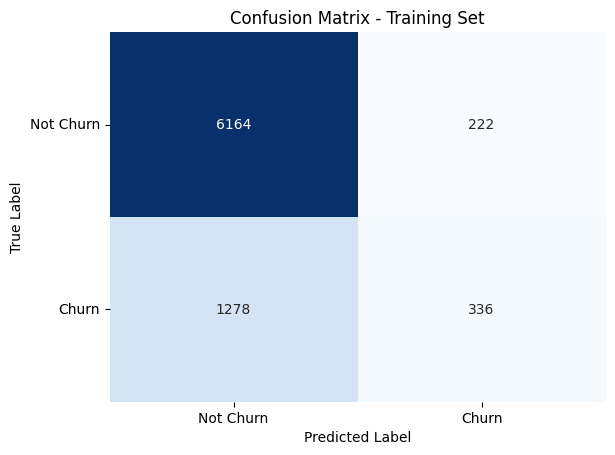

In [21]:
confusion_matrix_plot(lr_tuned, X = X_train_std, y = y_train)

In [42]:
model_metrics_print(lr_tuned,
                        X_train_std, 
                        y_train,  
                        X_test_std, 
                        y_test,  
                        model_name='LR Tuned',
                        data_type='test' 
                       )

LR Tuned Train Accuracy: 0.8125
LR Tuned Test Accuracy: 0.8125
----------
LR Tuned Test Precision: 0.6363636363636364
LR Tuned Test Recall: 0.2647754137115839
LR Tuned Test F1: 0.3739565943238731


Threshold tuning is needed because, with the default threshold (0.5), the model shows low recall despite high precision, meaning it's missing many positive cases (churners). Tuning the threshold helps balance precision and recall to better capture true positives, improving the overall F1 score and making the model more effective for the business goal.

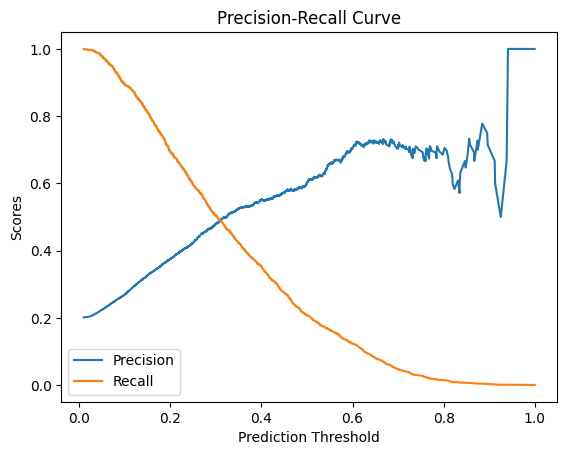

Optimal Threshold: 0.32396177513599317


In [24]:
# Plot the Precision-Recall Curve

# Get precision, recall, and thresholds from the precision-recall curve for the training set
# lr_tuned.predict_proba(X_train_std)[:,1] returns the predicted probabilities for the positive class (churn)
p_curve, r_curve, t_curve = precision_recall_curve(y_train, lr_tuned.predict_proba(X_train_std)[:,1])

# Plot precision against the thresholds
plt.plot(t_curve, p_curve[:-1], label='Precision')

# Plot recall against the thresholds
plt.plot(t_curve, r_curve[:-1], label='Recall')

# Add axis labels and a title for better clarity
plt.xlabel('Prediction Threshold')
plt.ylabel('Scores')
plt.title('Precision-Recall Curve')

# Add a legend to distinguish between precision and recall curves
plt.legend(loc='best')

# Display the plot
plt.show()

# Find the best threshold where precision is greater than 0.5 and recall is maximized
valid_indices = [i for i, p in enumerate(p_curve[:-1]) if p > 0.5]  # Ensure precision > 0.5

if valid_indices:
    # Get the index where recall is maximized among valid indices
    best_index = max(valid_indices, key=lambda i: r_curve[i])
    
    # Get the corresponding threshold value for that index
    tuned_thresh = t_curve[best_index]
    
    # Print the optimal threshold found
    print(f'Optimal Threshold: {tuned_thresh}')
else:
    # If no threshold satisfies precision > 0.5, print a message
    print('No threshold found with precision > 0.5.')

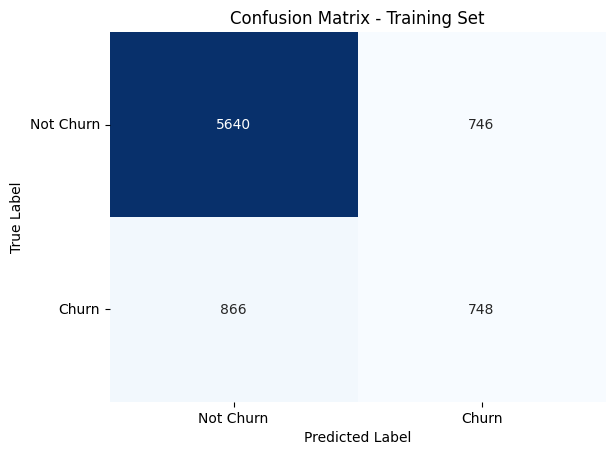

In [25]:
confusion_matrix_plot(lr_tuned, 
                          X = X_train_std,
                          y = y_train,
                          label = 'Training',
                          threshold = tuned_thresh
                         )

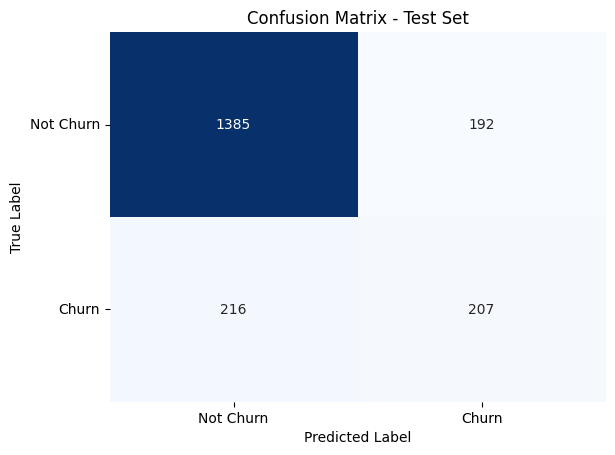

In [26]:
confusion_matrix_plot(lr_tuned, 
                          X = X_test_std,
                          y = y_test,
                          label = 'Test',
                          threshold = tuned_thresh
                         )

In [44]:
model_metrics_print(lr_tuned,
                        X_train_std, 
                        y_train,  
                        X_test_std, 
                        y_test,  
                        model_name='LR Tuned',
                        data_type='test',
                        threshold = tuned_thresh
                       )

LR Tuned Threshold Value: 0.32396177513599317
LR Tuned Train Accuracy at Threshold: 0.7985
LR Tuned Test Accuracy at Threshold: 0.796
----------
LR Tuned Test Precision: 0.518796992481203
LR Tuned Test Recall: 0.48936170212765956
LR Tuned Test F1: 0.5036496350364964


The tuned model with the adjusted threshold of 0.324 provides a balanced performance, with an accuracy of 79.6%, precision of 51.88%, recall of 48.94%, and an F1 score of 50.36%.

Compared to the default threshold (0.5) model, which had higher precision but lower recall, the threshold tuning has effectively increased recall while maintaining reasonable precision. This trade-off helps capture more true churners (higher recall), at the expense of slightly more false positives (lower precision). Overall, the threshold tuning results in a more balanced F1 score, making the model better suited for identifying churners while still keeping precision in check.

### **Random Forest**

In [46]:
# Initialize the Random Forest classifier with a fixed random state for reproducibility and use all CPU cores available (n_jobs=-1)
rf = RandomForestClassifier(random_state=2023, n_jobs=-1)

# Fit the Random Forest model on the training data
rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=2023)

In [49]:
model_metrics_print(rf,
                    X_train, 
                    y_train,  
                    X_test, 
                    y_test,  
                    model_name='RF',
                    data_type='test'
                   )

RF Train Accuracy: 1.0
RF Test Accuracy: 0.836
----------
RF Test Precision: 0.7111111111111111
RF Test Recall: 0.37825059101654845
RF Test F1: 0.49382716049382713


The Random Forest model shows severe overfitting, with 100% accuracy on the training set, indicating it's memorizing the data rather than generalizing. The test accuracy drops to 83.6%, and although precision is decent at 71.1%, the low recall (37.8%) suggests the model is missing a significant portion of actual churners. The F1 score (49.4%) confirms that the model needs significant tuning to improve generalization and recall.

In [35]:
evaluate_model_thresholds(rf, X_train, y_train, X_test, y_test, model_name='RF')

Performance of RF at Different Thresholds:


,Train Accuracy,Test Accuracy,Accuracy Difference,Test Precision,Test Recall,Test F1 Score
Threshold,,,,,,
0.10,0.848875,0.5770,0.271875,0.322716,0.910165,0.476485
0.15,0.947375,0.6885,0.258875,0.388641,0.825059,0.528388
0.20,0.975500,0.7510,0.224500,0.447699,0.758865,0.563158
0.25,0.990875,0.7905,0.200375,0.503448,0.690307,0.582253
0.30,0.997625,0.8085,0.189125,0.542735,0.600473,0.570146
0.35,0.999125,0.8190,0.180125,0.578406,0.531915,0.554187
0.40,1.000000,0.8290,0.171000,0.625387,0.477541,0.541555
0.45,1.000000,0.8325,0.167500,0.664179,0.420804,0.515195
0.50,1.000000,0.8360,0.164000,0.711111,0.378251,0.493827


The untuned Random Forest model exhibits poor performance, as observed across various decision thresholds. It struggles to effectively balance precision, recall, and generalization between the training and test sets. This suggests that without proper tuning, the default Random Forest configuration is not suitable for the current classification task, particularly for identifying churners.

In [36]:
# Define the Random Forest classifier with a fixed random state for reproducibility and parallel processing (n_jobs=-1)
rf = RandomForestClassifier(random_state=2023, n_jobs=-1)  

# Define the hyperparameters to tune using RandomizedSearchCV
# - 'n_estimators': Number of trees in the forest (range from 50 to 450 with step of 100)
# - 'max_features': Number of features to consider for each split (set to "sqrt" for limiting features)
# - 'bootstrap': Whether to use bootstrapping when building trees (set to True)
# - 'max_samples': Proportion of samples to draw for each tree (testing 50% and 90%)
# - 'max_depth': Maximum depth of the tree (ranging from 3 to 11, with step of 2)
# - 'min_samples_leaf': Minimum number of samples required to be a leaf node (testing values from 3 to 20)
params = {
    'n_estimators': np.arange(start=50, stop=450, step=100),
    'max_features': ["sqrt"],
    'bootstrap': [True],
    'max_samples': [.5, .9],
    'max_depth': np.arange(start=3, stop=11, step=2),
    'min_samples_leaf': [3, 5, 10, 20],
}

# Define the cross-validation strategy using StratifiedKFold for balanced splits across target classes
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2023)  # Ensures consistent splits

# Perform RandomizedSearchCV to search for the best hyperparameters
# - 'n_iter': Limit the number of parameter combinations to test (set to 100 iterations)
# - 'scoring': Optimize for 'recall' to focus on correctly identifying churners
# - 'random_state': Ensure consistent random sampling of hyperparameters
# - 'cv': Use StratifiedKFold for cross-validation
grid_rf = RandomizedSearchCV(
    rf, 
    params,
    n_iter=50,
    scoring='recall',
    random_state=2023,  # Ensure consistent random sampling of parameters
    cv=cv  # Use consistent cross-validation splits
)

# Fit the RandomizedSearchCV on the training data
grid_rf.fit(X_train, y_train)

# Get and display the best hyperparameters found during the search
best_params = grid_rf.best_params_
best_params

{'n_estimators': np.int64(250),
 'min_samples_leaf': 10,
 'max_samples': 0.9,
 'max_features': 'sqrt',
 'max_depth': np.int64(9),
 'bootstrap': True}

{'n_estimators': np.int64(150),
 'min_samples_leaf': 3,
 'max_samples': 0.5,
 'max_features': 'sqrt',
 'max_depth': np.int64(9),
 'bootstrap': True}

In [37]:
# Narrow the hyperparameter search space based on the results from the previous RandomizedSearchCV

params = {
    'n_estimators': [125, 150, 175],  # Fine-tune around the best result (150) with a narrower range
    'bootstrap': [True], # Keep "sqrt" based on the previous result
    'max_features': ['sqrt'],  # Based on RandomizedSearchCV result
    'max_samples': [0.5],  # Based on RandomizedSearchCV result
    'max_depth': [9, 10, 12],  # Fine-tune around the best depth (9) with values slightly above and below
    'min_samples_leaf': [3, 4]  # Fine-tune around the best value (3) with a small adjustment (3, 4)
}

# Perform a more refined GridSearchCV for finer hyperparameter tuning
# This will search the narrowed parameter space and optimize for 'recall'
grid_rf_fin = GridSearchCV(
    rf, 
    params,
    scoring='recall',  # Optimize for recall to capture more churners
    cv=cv  # Use StratifiedKFold cross-validation for consistent evaluation
)

# Fit the GridSearchCV on the training data to find the best hyperparameters
grid_rf_fin.fit(X_train, y_train)

# Get and display the best parameters after fine-tuning
grid_rf_fin.best_params_

{'bootstrap': True,
 'max_depth': 12,
 'max_features': 'sqrt',
 'max_samples': 0.5,
 'min_samples_leaf': 3,
 'n_estimators': 150}

In [38]:
# Initialize the Random Forest classifier with the best hyperparameters found through GridSearchCV
rf_tuned = RandomForestClassifier(random_state=2023, n_jobs=-1, **grid_rf_fin.best_params_)

# Fit the tuned Random Forest model on the training data
rf_tuned.fit(X_train, y_train)

RandomForestClassifier(max_depth=12, max_samples=0.5, min_samples_leaf=3,
                       n_estimators=150, n_jobs=-1, random_state=2023)

In [50]:
model_metrics_print(rf_tuned,
                    X_train, 
                    y_train,  
                    X_test, 
                    y_test,  
                    model_name='RF Tuned',
                    data_type='test'
                   )

RF Tuned Train Accuracy: 0.87525
RF Tuned Test Accuracy: 0.836
----------
RF Tuned Test Precision: 0.7386934673366834
RF Tuned Test Recall: 0.3475177304964539
RF Tuned Test F1: 0.47266881028938906


In [40]:
evaluate_model_thresholds(rf_tuned, X_train, y_train, X_test, y_test, model_name='RF Tuned')

Performance of RF Tuned at Different Thresholds:


,Train Accuracy,Test Accuracy,Accuracy Difference,Test Precision,Test Recall,Test F1 Score
Threshold,,,,,,
0.10,0.621125,0.5445,0.076625,0.306962,0.917258,0.459988
0.15,0.763375,0.6815,0.081875,0.383442,0.832151,0.524981
0.20,0.847125,0.7590,0.088125,0.457797,0.756501,0.570410
0.25,0.888375,0.7925,0.095875,0.507547,0.635934,0.564533
0.30,0.900750,0.8090,0.091750,0.548009,0.553191,0.550588
0.35,0.902125,0.8260,0.076125,0.608069,0.498818,0.548052
0.40,0.896375,0.8320,0.064375,0.654804,0.434988,0.522727
0.45,0.886000,0.8330,0.053000,0.696035,0.373522,0.486154
0.50,0.875250,0.8360,0.039250,0.738693,0.347518,0.472669


It seems like the threshold tuning isn't providing much improvement, especially given the diminishing returns in performance as the threshold increases. The precision improves at higher thresholds, but the recall drops significantly, which might is not helpful for our goal of identifying churners.

### **GBM**

In [51]:
# Initialize the Gradient Boosting Classifier with a fixed random state for reproducibility
gbm = GradientBoostingClassifier(random_state=2023)

# Fit the Gradient Boosting model on the training data
gbm.fit(X_train, y_train)

GradientBoostingClassifier(random_state=2023)

In [52]:
model_metrics_print(gbm,
                    X_train, 
                    y_train,  
                    X_test, 
                    y_test,  
                    model_name='GBM',
                    data_type='test'
                   )

GBM Train Accuracy: 0.85875
GBM Test Accuracy: 0.8405
----------
GBM Test Precision: 0.7241379310344828
GBM Test Recall: 0.3971631205673759
GBM Test F1: 0.5129770992366413


The default parameters of the Gradient Boosting Model (GBM) perform very well, achieving a training accuracy of 85.88% and a test accuracy of 84.05%, with strong precision (0.724) and a balanced F1 score (0.513). While the recall is relatively modest at 0.397, attempts to tune the model’s hyperparameters to improve recall resulted in overfitting, with the training accuracy increasing and the test accuracy declining. Therefore, it is recommended to keep the GBM with its default parameters, as further tuning does not provide significant improvement and may compromise the model’s ability to generalize well, especially in terms of recall.Tuning the threshold may be a way to improve recall instead.

In [166]:
evaluate_model_thresholds(gbm, X_train, y_train, X_test, y_test, model_name='GBM')

Performance of GBM at Different Thresholds:


,Train Accuracy,Test Accuracy,Accuracy Difference,Test Precision,Test Recall,Test F1 Score
Threshold,,,,,,
0.10,0.602750,0.5980,0.004750,0.333041,0.898345,0.485934
0.15,0.727250,0.7275,-0.000250,0.425791,0.827423,0.562249
0.20,0.795125,0.7710,0.024125,0.473035,0.725768,0.572761
0.25,0.829625,0.7985,0.031125,0.519084,0.643026,0.574446
0.30,0.845375,0.8165,0.028875,0.564516,0.579196,0.571762
0.35,0.854250,0.8260,0.028250,0.601626,0.524823,0.560606
0.40,0.857000,0.8320,0.025000,0.636364,0.479905,0.547170
0.45,0.858250,0.8345,0.023750,0.670370,0.427896,0.522367
0.50,0.858750,0.8405,0.018250,0.724138,0.397163,0.512977


In [54]:
model_metrics_print(gbm,
                    X_train, 
                    y_train,  
                    X_test, 
                    y_test,  
                    model_name='GBM',
                    data_type='test',
                    threshold = 0.3
                   )

GBM Threshold Value: 0.3
GBM Train Accuracy at Threshold: 0.845375
GBM Test Accuracy at Threshold: 0.8165
----------
GBM Test Precision: 0.5645161290322581
GBM Test Recall: 0.5791962174940898
GBM Test F1: 0.5717619603267211


Tuning the classification threshold has proven to be an effective way to improve recall. By adjusting the threshold to 0.30, I was able to increase recall to 0.579 (up from 0.397) while maintaining a decent precision of 0.565 and minimizing overfitting. This threshold tuning allowed the model to better capture customers at risk of churn, which aligns with the business goal of maximizing retention efforts. Accuracy is 0.8165, only slightly below the higher thresholds, so we are not sacrificing overall accuracy.

## Step 4: Final Comparison of Models for Selection
1. Compare metrics on test dataset for all models.
2. Generate ROC AUC and plot ROC curves for all models.

In [168]:
# This code automates the process of printing performance metrics for multiple models in a concise way.
# - First, I define a list of tuples (`models`), where each tuple contains:
#   (1) The model name (as a string) for easy identification in the output,
#   (2) The corresponding predictions for the test set, which includes both standard predictions and threshold-tuned predictions.
# - The function `print_all_metrics` is responsible for:
#   - Iterating over each model in the list.
#   - Calculating and printing key performance metrics (accuracy, precision, recall, F1 score) for each model.
#   - The true test labels (`y_test`) are passed once, and the function handles comparing these with the predictions of each model.
# This approach allows for all models to be evaluated and compared in a single step, 
# reducing redundancy and automating the process of printing metrics for both standard and threshold-tuned models.

# List of model names and their corresponding predictions
models = [
    ('Logistic Regression Tuned', lr_tuned.predict(X_test_std)),
    ('Logistic Regression Threshold Tuned', (lr_tuned.predict_proba(X_test_std)[:, 1] > tuned_thresh).astype(int)),
    ('Random Forest Tuned', rf_tuned.predict(X_test)),
    ('GBM', gbm.predict(X_test)),
    ('GBM Threshold Tuned', (gbm.predict_proba(X_test)[:, 1] > tuned_thresh).astype(int))
]

# Function to print metrics for all models
def print_all_metrics(models, y_true):
    for model_name, y_pred in models:
        print(f'{model_name} Test Accuracy: {np.round(accuracy_score(y_true, y_pred),3)}')
        print(f'{model_name} Test Precision: {np.round(precision_score(y_true, y_pred),3)}')
        print(f'{model_name} Test Recall: {np.round(recall_score(y_true, y_pred),3)}')
        print(f'{model_name} Test F1: {np.round(f1_score(y_true, y_pred),3)}')
        print('----------')

# Call the function to print metrics for all models
print_all_metrics(models, y_test)

Logistic Regression Tuned Test Accuracy: 0.812
Logistic Regression Tuned Test Precision: 0.636
Logistic Regression Tuned Test Recall: 0.265
Logistic Regression Tuned Test F1: 0.374
----------
Logistic Regression Threshold Tuned Test Accuracy: 0.796
Logistic Regression Threshold Tuned Test Precision: 0.519
Logistic Regression Threshold Tuned Test Recall: 0.489
Logistic Regression Threshold Tuned Test F1: 0.504
----------
Random Forest Tuned Test Accuracy: 0.836
Random Forest Tuned Test Precision: 0.739
Random Forest Tuned Test Recall: 0.348
Random Forest Tuned Test F1: 0.473
----------
GBM Test Accuracy: 0.84
GBM Test Precision: 0.724
GBM Test Recall: 0.397
GBM Test F1: 0.513
----------
GBM Threshold Tuned Test Accuracy: 0.818
GBM Threshold Tuned Test Precision: 0.575
GBM Threshold Tuned Test Recall: 0.541
GBM Threshold Tuned Test F1: 0.558
----------


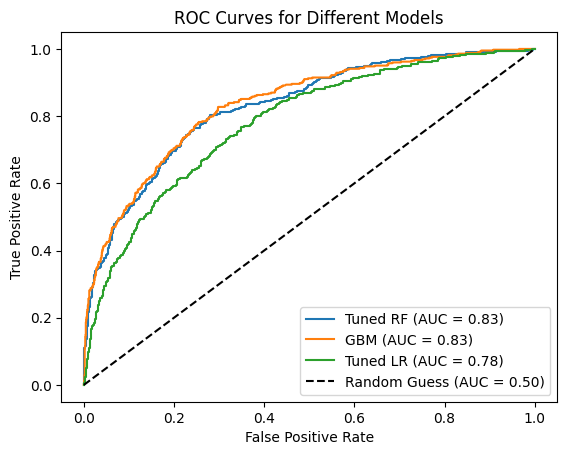

In [170]:
# Generate ROC AUC and plot ROC curves for multiple models (Tuned Random Forest, GBM, and Tuned Logistic Regression)
# This will allow a visual comparison of how well each model distinguishes between churners and non-churners across all thresholds.

# For each models: 
# Get the probabilities of the positive class (churn) for the test set
# Calculate false positive rate and true positive rate
# Calculate the area under the ROC curve (AUC) for the model

# Generate ROC AUC for the tuned Random Forest model
y_probs_rf = rf_tuned.predict_proba(X_test)[:, 1]  
fpr1, tpr1, thresholds = roc_curve(y_test, y_probs_rf)  
auc_score_rf = auc(fpr1, tpr1) 

# Generate ROC AUC for the GBM model
y_probs_gb = gbm.predict_proba(X_test)[:, 1]  
fpr2, tpr2, thresholds = roc_curve(y_test, y_probs_gb)  
auc_score_gb = auc(fpr2, tpr2)

# Generate ROC AUC for the tuned Logistic Regression model
y_probs_lr = lr_tuned.predict_proba(X_test_std)[:, 1] 
fpr3, tpr3, thresholds = roc_curve(y_test, y_probs_lr) 
auc_score_lr = auc(fpr3, tpr3)  

# Plot the ROC curves for the tuned models
plt.plot(fpr1, tpr1, label=f'Tuned RF (AUC = {auc_score_rf:.2f})')  # Random Forest
plt.plot(fpr2, tpr2, label=f'GBM (AUC = {auc_score_gb:.2f})')  # GBM
plt.plot(fpr3, tpr3, label=f'Tuned LR (AUC = {auc_score_lr:.2f})')  # Logistic Regression

# Plot a random guess line (AUC = 0.50) for reference
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.50)')

# Modify the plot with axis labels, title, and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend()

# Show the ROC curve plot
plt.show()

**Model Comparison Summary**
The primary goal of this project is to **maximize recall**, ensuring we capture as many churners as possible, even if it means tolerating some false positives. Based on the results, we can compare the performance of Logistic Regression, Random Forest, and Gradient Boosting (GBM) models.

**AUC Comparison:**
From the ROC AUC curves, GBM and Random Forest both show strong overall performance with an AUC of 0.83, compared to 0.78 for Logistic Regression. This indicates that both GBM and Random Forest are better at distinguishing churners from non-churners across all thresholds.

**Precision, Recall, and F1 Score Comparison:**

* Logistic Regression struggles with recall, especially in its default form. Even after threshold tuning, the recall only reaches 0.489, which is insufficient for the goal of capturing most churners.
* Random Forest provides high precision (0.739), but the recall remains low at 0.348, meaning it misses a significant number of churners.
* GBM stands out, especially after threshold tuning. It achieves a recall of 0.541, the highest among all models, while maintaining a reasonably balanced precision (0.575) and F1 score (0.558).

**Best Model for Recall:**
Given the primary objective is recall, GBM with threshold tuning is the clear winner. It captures over 54% of the churners, which is the best trade-off between capturing churners and managing false positives. This makes it the most suitable model for identifying customers who are likely to churn, allowing the bank to take preemptive action to retain them.

I will also perform a **feature importance analysis** to identify the key drivers behind customer churn. Understanding which features are most influential will provide valuable insights for the business, allowing more targeted and effective retention strategies. This will also help interpret the model’s decision-making process, ensuring transparency in how the model flags customers at risk of churning.

## Step 5: Additional Analysis
1. Perform a feature importance analysis.
2. Perform SHAP analysis
3. Provide recommendations to help minimise churn

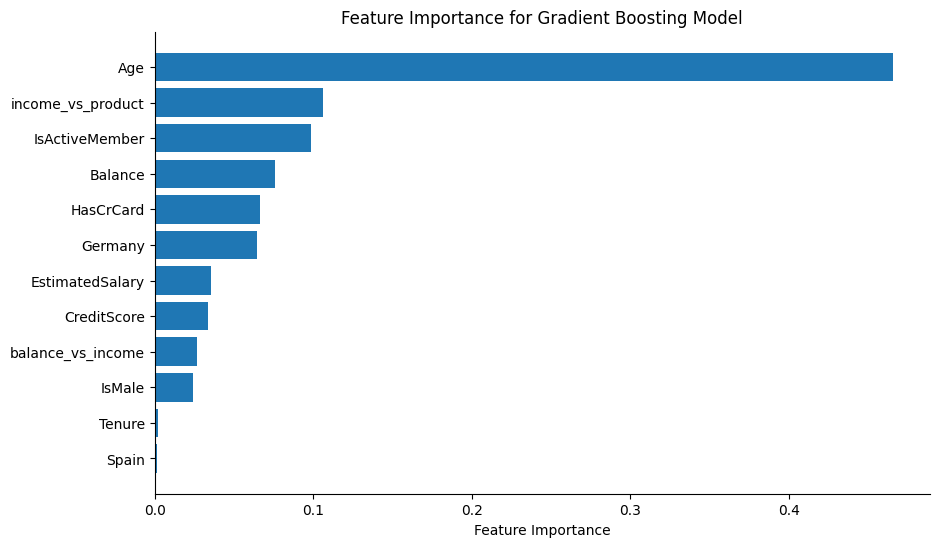

In [171]:
# Feature importance from the tuned GBM model (no need to apply threshold tuning here)
feature_importances = gbm.feature_importances_  # Use the trained GBM model to get feature importances
sorted_idx = np.argsort(feature_importances)  # Sort the features by importance

# Plotting the feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [features[i] for i in sorted_idx])  # Map the sorted feature indices back to feature names
plt.xlabel('Feature Importance')
plt.title('Feature Importance for Gradient Boosting Model')
sns.despine()
plt.show()

* **Most Important**: Age is clearly the dominant feature, standing out with a significantly higher importance compared to all other features.
* **Moderate Importance**: Income vs Product and IsActiveMember are in a second tier, showing relatively high importance but still considerably lower than Age.
* **Lower but Relevant Importance**: Balance, HasCrCard, and Germany have similar importance and fall into a third tier. These features are relevant but not as critical as the top two group

This grouping reflects the different levels of influence these features have on customer churn, guiding where the business should focus for more effective customer retention strategies.

In [59]:
# Import SHAP 
import shap

# Create explainer object
explainer = shap.Explainer(gbm)

# Calculate SHAP values for a sample of 200 instances from the test dataset
shap_values = explainer(X_test.sample(200, random_state=2023))

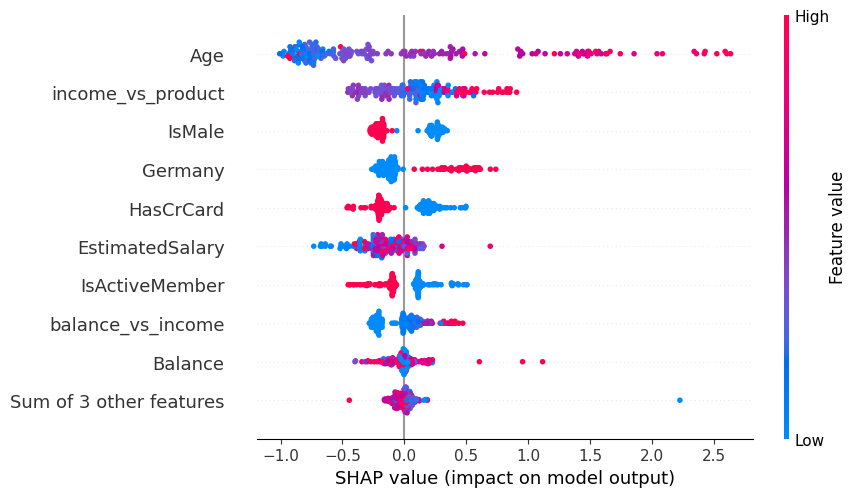

In [60]:
# Generate a beeswarm plot for the SHAP values of all selected instances in the dataset
# The beeswarm plot shows the distribution of SHAP values for each feature across all instances
# Features are sorted by their average impact on the model output, with the most impactful at the top

shap.plots.beeswarm(shap_values)

**IsMale, IsActiveMember**, **HasCrCard** and **Germany** are boolean features, the color gradient in the SHAP beeswarm plot represents just two possible values:
* **Blue** represents a 0 (False), meaning:
  - IsMale = 0: The customer is female.
  - IsActiveMember = 0: The customer is not an active member.
  - HasCrCard = 0: The customer does not have a credit card.
  - Germany  = 0: The customer is not from Germany.
* **Red** represents a 1 (True), meaning:
  - IsMale = 1: The customer is male.
  - IsActiveMember = 1: The customer is an active member.
  - HasCrCard = 1: The customer has a credit card.
  - Gemany = 1: The customer is from Germany.

**Shap Plot Interpretation:**

* **Age**: Higher age (red dots) pushes the prediction toward churn, while lower age (blue) decreases churn risk.
* **income_vs_product**: Higher values (red) push the prediction towards churn.
* **IsMale**: The SHAP values show mixed results. Being male (red) slightly decreases the churn risk for some customers, while being female (blue) has a more positive effect on the churn risk, indicating females are more likely to churn in some cases.
* **IsActiveMember**: Being an active member (red) decreases churn risk, while not being active (blue) increases churn risk.
* **HasCrCard**: The SHAP values show that having a credit card (red) slightly decreases the likelihood of churn, while not having one (blue) can increase churn risk, depending on the customer.
* **Germany**: Being from Germany (red) tends to increase churn risk, while not being from Germany (blue) tends to reduce it.
* **EstimatedSalary**: Lower salaries (blue) generally increase churn risk. Higher salaries (red) typically reduce churn risk, but not dramatically. The impact of a high salary seems to have a neutral to slightly positive effect in reducing churn.
* **balance_vs_income**: A higher balance relative to income increases churn risk.
* **Balance**: Mixed but mostly neutral effect on churn for most customers. It's neither a strong driver of churn nor a strong factor in retention for the majority of cases.
* **Sum of 3 Other Features**: These features individually don't have a significant impact but cumulatively contribute slightly to the prediction.

#### **Top 5 Features and Recommendations to Reduce Churn**

**Age**
* Recommendation: Implement age-specific engagement programs for older customers (especially 40+), such as personalized offers, retirement-focused financial products, or loyalty rewards. Proactive communication and support can help keep older customers engaged and reduce churn risk.

**Income vs Product**
* Recommendation: Encourage higher product utilization by offering personalized product recommendations based on customer income levels. Consider bundling services to provide better value and increase customer engagement with more products.

**IsActiveMember**
* Recommendation: Develop strategies to reactivate inactive customers, such as targeted campaigns, incentives for frequent use, and loyalty programs. Encourage engagement by offering rewards for activity and making it easier for customers to access and use your services.

**Estimated Salary**
* Recommendation: Focus on lower-income customers by offering financial support products (e.g., lower fees, flexible savings options) and incentivizing engagement through discounts or special promotions. Educating lower-salary customers on how to use more services can help reduce churn.

**IsMale (Gender)**
* Recommendation: Create targeted retention campaigns for female customers, as they have a higher risk of churn. Offer gender-sensitive communication, personalized offers, and products that cater to their needs, emphasizing security and investment opportunities.